#### Analysis of multiple stocks - for simulation over the course of n years at variable buy in frequency

Goal: This script simulates any number (typically 2) years of n-weekly prediction/closing_cost determinations and simulates for a series of chosen stocks if it is better to invest a consistent price or buy in higher/lower depending on the current performance of the stock.

Take any number of stocks and run a trendline through a series of overlapping cycles of variable length, creating a linear prediction to be applied. Assess the theoretical performance of adjusting contributions as compared to contributing a consistent amount over time.


In [474]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import math
from sys import exit

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

In [475]:
### doing
# Add functions
    # Define a function for each strategy. Opt1, opt2 etc. Should be able to get them down to a few variables
# Add comprehensions


### To do
# fix the copy errors - do it right


### bigger changes that might warrant a new doc entirely
# be able to do any unit of time, not just days - make it 'units' of time
    # so I can check on hypothetical minute to minute trading
# Start testing buy/sell every period based on a set budget
    # will likely be a big job. maybe a lot of changes needed
    # will possibly need to make it it's own script
    # I do still want to compare to a standard buy and hold consistently approach as the baseline


### Fixed/Done
# are all ranges 1-260 or are some 0-259? - one of them was corrected, the one that sets the pred independent variable (aka index)
# test the dynamic roll_days - is it implemented everywhere it should be and everything works as expected? - seems good now
# Fix the graphs to be dynamic for dates - esp the 3 graphs stuck together - can I make the number of stuck visuals dynamic? - dropped for now
# Fix the final statement to say profit/loss or above/below dynamically
    # seems to have an issue with the reversal of percents when the total profits are negative
    # need to test with net loss stocks
# Test for different 3 year periods of time
# Fact check the dynamic dates - is everything really working?
# I really need to fix the invest days to be always on Monday or something instead of every 10 trading days
    # I can't actually trust this method until I do this
    # probably means actually using time series instead of the index replacement -- nope
# be able to run on SP500
    # SP500 core profit is unbeleiveable - any error in the code? -- a few 'weeks' variables were kept stagnant as 49
# error checking on too much history run
    # have a whole section dedicated to it and say which stock and by how much it misses
# Make a path to DL data and call to it again w/o issues
    # For flights w/o internet
# be able to do one stock at a time -- OR be able to bypass
# 3 options: every week, 2 weeks, 4 weeks, is ok if I can't do fully dynamic
# test nth week variable for odd n's that create non-integers, like investing on 3rd weeks
    # invest_weeks must be an integer
    # re-check all new facets of weeks and invest_weeks
# convert 'y' years of data to be 'w?' weeks.
    # calculate exactly how much data are needed based on weeks to look back + length of the regression. with a week or two buffer
# make the invest period dynamic
# make some logic to warn when I'm asking for too much data and one of the stocks hasn't been around long enough
# Fact check by trying different stocks entirely - do a series of poorly performing stocks, high performing stocks, and a mix
# swap to open instead of open, it's more true to my practice
# I'm picking heavy hitter stocks and then pretending I've been investing for 2 years
    # I need to pick a series of random stocks and see if I still beat baseline
# Add individual buy in prices. 
    # Do a 2 variable loop along with my j stock variable? Do a pre logic to pick custom buy ins or make all the same if only one chosen
# get opt5 ready or some other method
# something wrong with the last table output - opt 5, when pred/open2 > 1.2
    # the df data are ok, but this needs to be fixed ASAP
# add in flight 1 and flight 2 of biweekly options
# find BTC data - must do
    # either through another package or manual DL and upload
    # does the fact that BTC is daily mess up the code?
# optimize the code that creates the pred calculation. Only the last row in each dictionary entry is used



In [476]:
##### User choices go here #####

# choose stocks of interest
# stocks chosen must all have data for full range of dates
stock_list = ['AAPL', 'AMD', 'AMZN', 'CRM', 'GOOG', 'INTC', 'MSFT', 'NVDA', 'QQQ', 'SBUX', 'SQ', 'TSLA', 'TSM'] # core list
# stock_list = ['AAPL', 'AMZN', 'GOOG', 'INTC', 'MSFT', 'SBUX', 'SQ'] # flight 1
# stock_list = ['AMD', 'CRM', 'NVDA', 'QQQ', 'TSLA', 'TSM'] # flight 2
# stock_list = ['^GSPC'] # AKA S&P 500
# stock_list = ['VFIAX', 'VTIAX', 'VTSAX']
# stock_list = ['BTC-USD']
# stock_list = ['AAPL', 'SQ', 'TSLA'] # quicker for test runs
# stock_list = ['TDOC', 'PINS'] # for net loss test runs
# stock_list = ['OSBC', 'MZZ', 'AEPPL', 'LDOS', 'AXU', 'ACM', 'MIND', 'PESI', 'JBT', 'FMN', ] # randomly pulled stocks

# choose how much to contribute each weekly period
# may choose a single value for all stocks or a set of tailored values per stock
contrib_amt = [20, 15, 10, 5, 10, 15, 10, 15, 10, 10, 10, 20, 15] # for core list
# contrib_amt = [20, 10, 10, 15, 10, 10, 10] # flight 1
# # contrib_amt = [15, 5, 15, 10, 20, 15] # flight 2
# contrib_amt = [10]
# contrib_amt = [25]
# contrib_amt = [350, 50, 100] # for 3 index list

# weeks to cover (not necessarily the number of weeks where investing occurs)
# 52 = 1 year, 104 = 2 years, etc
total_weeks = 104

# invest every nth week
# 1 = every week, 2 = every 2 weeks, etc
nth_week = 2

# number of days to roll into each linear regression.
# 260 will be about 1 year
# 65 will be about 1 quarter
# 21 will be about 1 month
# remember, a trading week is a bit less than 5 days on average
roll_days = 65

# opt 5: threshold of consistent buying vs increased buying
buyvalue = 1.2

# opt 5: if buyvalue hits, how much to multiply
# current strategy is (contrib_amt * pred/open2 * multiplier)
multiplier = 3

# opt 6: if buyvalue hits, how much to multiply
# current strategy is (contrib_amt * multiplier)
multiplier2 = 3



##### choices on the fence, maybe they should be actively chosen #####

# max amount to contribute per stock over the course of 2 years
# should be at least 50 times the bi-weekly contrib
# unlimited max is another viable strategy
invest = float('inf')
# invest = contrib_amt*invest_weeks


##### 'choices' that should really be left alone #####

# number of years to visualize
if stock_list == ['BTC-USD']:
    day_hist = (total_weeks*7)+roll_days+1 # choose for crypto ~ trading every day
else:
    day_hist = (total_weeks*5)+roll_days+1 # choose for stocks ~ trading about 5 days per week

# weeks to actually invest on
invest_weeks = math.floor(total_weeks/nth_week)


print('Total invest amount over', total_weeks, 'weeks:', invest)
print('Number of invest weeks:', invest_weeks)
print('Days of data to pull:', day_hist)


Total invest amount over 104 weeks: inf
Number of invest weeks: 52
Days of data to pull: 586


In [477]:
# duplicate contrib_amt for all stocks if only 1 listed
if len(contrib_amt) == len(stock_list):
    pass
elif len(contrib_amt) == 1: 
    contrib_amt = [contrib_amt[0] for x in range(len(stock_list))]
else:
    print('Incorrect length of contrib_amt. Make it match the length of the stock list or be 1 value')
    exit()

contrib_amt

[20, 15, 10, 5, 10, 15, 10, 15, 10, 10, 10, 20, 15]

In [478]:
# Pull the data
df = yf.download(
        tickers = stock_list
        ,period = str(day_hist) + 'd'
        #,start = '2017-02-14' # to choose custom date ranges
        #,end = '2020-02-14' # to choose custom date ranges
    )

# allows a single stock to pass through, not just 2+ stocks. and passes through just closing
if len(stock_list) == 1:
    df[stock_list[0]] = df['Open']
    df = df[[stock_list[0]]]
else:
    df = df['Open']

# add an index and useable date
df['Index'] = np.arange(1,len(df)+1)
df['date'] = df.index

# error checking, if a stock doesn't have enough history based on the current needs
nlist = []
for i in stock_list:
    if pd.isna(df[i].iloc[0]) == True:
        nlist.append(i)
    else:
        pass

if len(nlist) >0:
    print('Stocks with not enough history', nlist)
    for j in nlist:
        print(j, 'missing days:', df['Index'].count()-df[j].count())
    exit() # Maybe not the best to add this. I still want to see the data
else:
    print('No stock history issues seen')

# in case the first row generates as nulls
# df = df.dropna() # not sure if necessary anymore

# establishing day of week, week number, trading day (each Monday)
df['dow'] = df['date'].dt.dayofweek
week_no_list = []
trade_day_list = []
week_no_var = 1
trade_day_var = 0

for i in range(len(df)):
    if i == 0:
        1
    elif df['dow'].iloc[i] > df['dow'].iloc[i-1]:
        week_no_var
        trade_day_var = 0
    else:
        week_no_var += 1
        trade_day_var = 1
    week_no_list.append(week_no_var)
    trade_day_list.append(trade_day_var)

df['week_no'] = week_no_list
df['trade_day'] = trade_day_list

df

[*********************100%***********************]  13 of 13 completed
No stock history issues seen


,AAPL,AMD,AMZN,CRM,GOOG,INTC,MSFT,NVDA,QQQ,SBUX,SQ,TSLA,TSM,Index,date,dow,week_no,trade_day
Date,,,,,,,,,,,,,,,,,,
2019-09-26,55.000000,29.670000,1762.790039,152.419998,1241.959961,50.980000,139.440002,44.459999,189.830002,90.839996,60.040001,46.132000,45.099998,1,2019-09-26,3,1,0
2019-09-27,55.134998,29.170000,1748.000000,153.119995,1243.010010,50.630001,140.149994,43.915001,189.729996,90.300003,60.980000,48.439999,46.000000,2,2019-09-27,4,1,0
2019-09-30,55.224998,28.889999,1726.989990,147.949997,1220.969971,51.189999,138.050003,43.200001,187.789993,88.410004,60.959999,48.599998,46.570000,3,2019-09-30,0,2,1
2019-10-01,56.267502,29.049999,1746.000000,149.490005,1219.000000,51.970001,139.660004,43.750000,189.500000,88.629997,62.299999,48.299999,46.959999,4,2019-10-01,1,2,0
2019-10-02,55.764999,28.500000,1727.739990,146.059998,1196.979980,50.310001,136.250000,43.279999,186.000000,85.949997,61.230000,48.658001,46.709999,5,2019-10-02,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-14,171.339996,131.679993,3203.000000,228.029999,2750.000000,54.849998,304.250000,263.000000,375.070007,101.910004,135.000000,1019.880005,136.089996,582,2022-01-14,4,121,0
2022-01-18,171.509995,134.500000,3182.100098,228.449997,2732.000000,55.310001,304.070007,262.600006,374.040009,99.169998,130.029999,1026.609985,136.750000,583,2022-01-18,1,122,1
2022-01-19,170.000000,133.550003,3175.239990,227.470001,2738.770020,54.630001,306.290009,260.790009,372.149994,97.940002,129.005005,1041.709961,134.619995,584,2022-01-19,2,122,0


In [479]:
# make a list of indices that are the Mondays where the trade should take place
# always starting with the most recent Monday

df_trade_days = df['Index'][df['trade_day'] == 1]
df_trade_days = df_trade_days.tail(total_weeks)
df_trade_days = df_trade_days.tolist()

def reverse(rev):
    rev.reverse()
    return rev
df_trade_days = reverse(df_trade_days)

nth_wk = df_trade_days[::nth_week]

print(nth_wk)
print('Number of weeks picked:',len(nth_wk))


[583, 573, 564, 554, 545, 535, 525, 515, 505, 495, 486, 476, 466, 456, 447, 437, 427, 418, 408, 398, 388, 379, 369, 359, 350, 340, 331, 321, 313, 303, 294, 284, 274, 264, 254, 244, 235, 225, 215, 205, 195, 186, 176, 167, 157, 147, 137, 128, 118, 108, 99, 89]
Number of weeks picked: 52


In [480]:
# create 1 dataframe per invest week in a dictionary, each the length of the chosen invest period
# 0 is the most recent

dataframes = {}

for j in stock_list:
    for i in range(invest_weeks):
        x = nth_wk[i]-roll_days # roll_days sets how many rows in each df
        y = nth_wk[i]

        dataframes['data' + str(i)] = df.iloc[x:y]

print(dataframes['data0'])
print(dataframes['data' + str(invest_weeks-1)])

                  AAPL         AMD         AMZN         CRM         GOOG  \
Date                                                                       
2021-10-15  143.770004  112.510002  3311.419922  292.489990  2844.000000   
2021-10-18  143.449997  111.900002  3388.360107  290.779999  2824.270020   
2021-10-19  147.009995  116.160004  3434.290039  292.100006  2865.830078   
2021-10-20  148.699997  116.290001  3452.659912  293.109985  2884.449951   
2021-10-21  148.809998  116.500000  3414.250000  289.470001  2843.840088   
...                ...         ...          ...         ...          ...   
2022-01-11  172.320007  133.449997  3230.000000  228.800003  2763.610107   
2022-01-12  176.119995  138.589996  3331.500000  237.000000  2831.090088   
2022-01-13  175.779999  139.440002  3305.010010  237.500000  2836.810059   
2022-01-14  171.339996  131.679993  3203.000000  228.029999  2750.000000   
2022-01-18  171.509995  134.500000  3182.100098  228.449997  2732.000000   

           

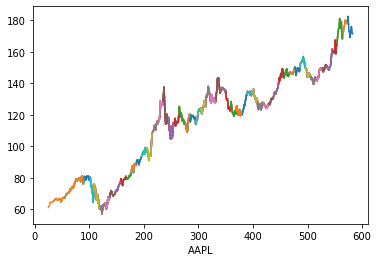

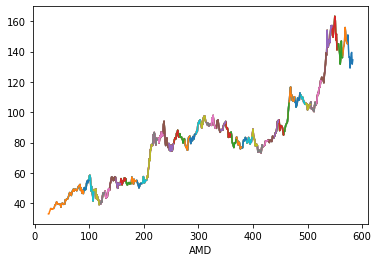

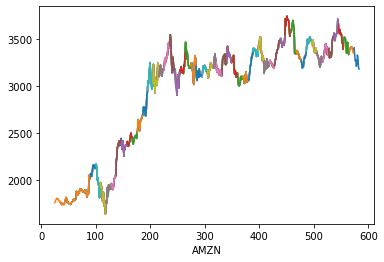

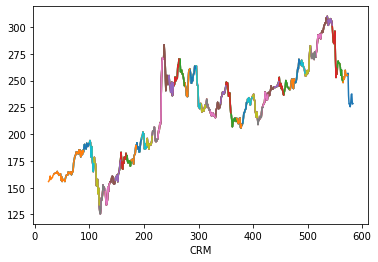

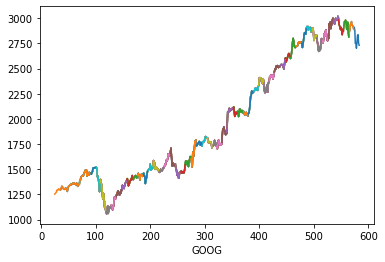

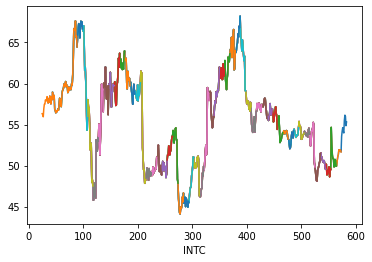

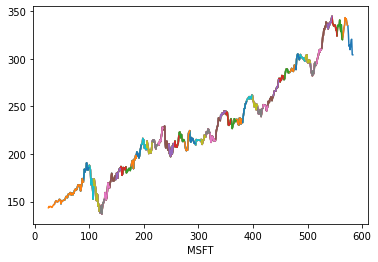

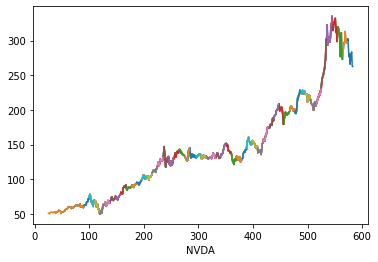

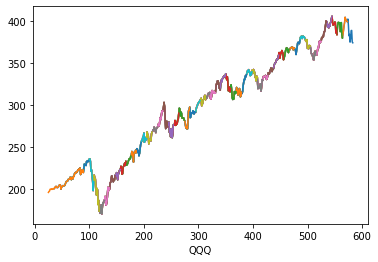

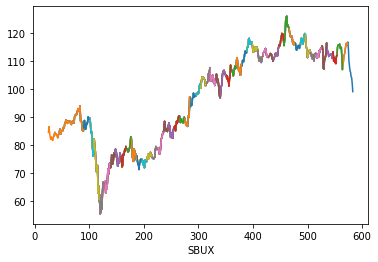

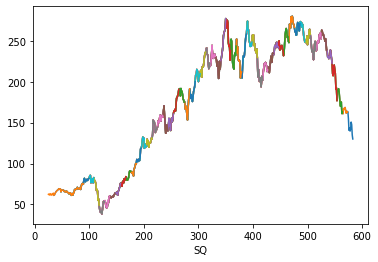

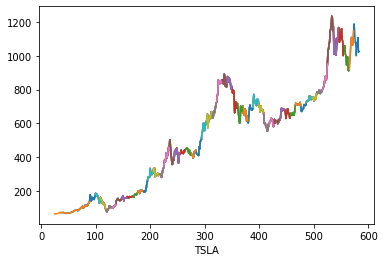

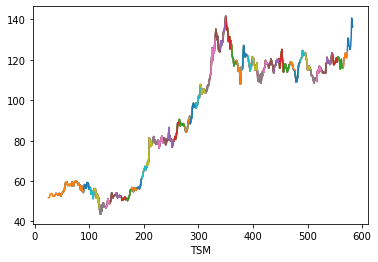

In [481]:
# shows each investing period, overlapping
### meh, less useful if I can't account for the dynamic investing periods

for i in stock_list:
    for j in range(len(dataframes)):
        x = dataframes['data' + str(j)]['Index']
        y = dataframes['data' + str(j)][str(i)]
        plt.plot(x, y)
        # m, b = np.polyfit(x, y, 1)
        # plt.plot(x, m*x + b)

    plt.xlabel(i)
    plt.show()

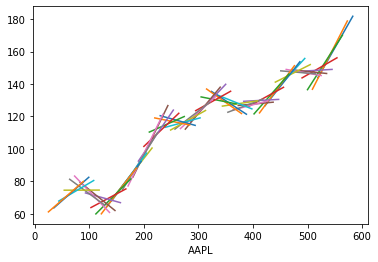

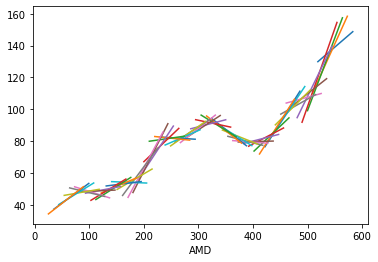

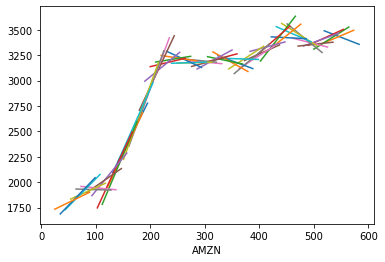

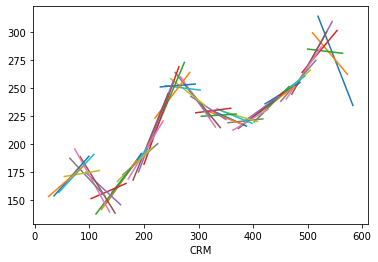

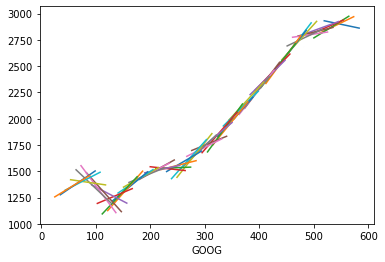

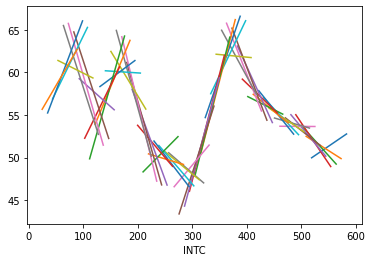

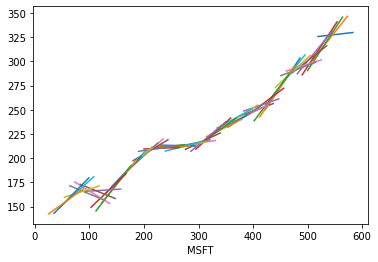

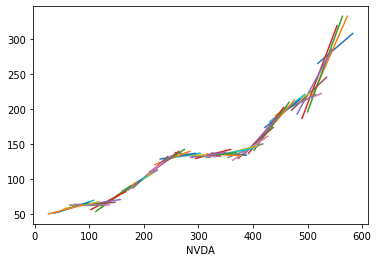

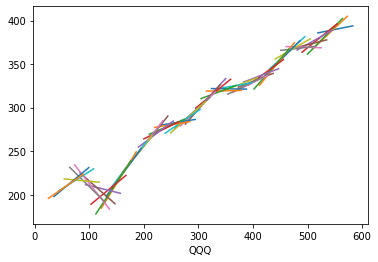

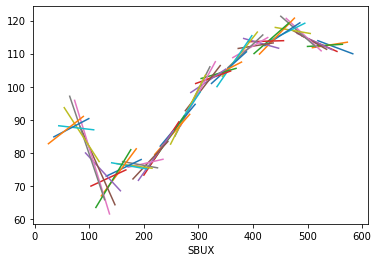

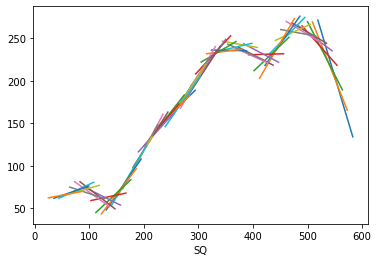

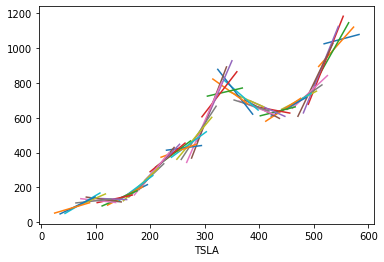

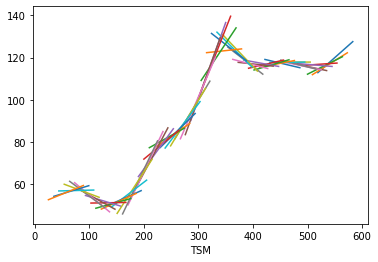

In [482]:
# plot only trendlines, every n weeks, each line representing the chosen length of data
# if the movement is too stable, these graphs won't be useable

for j in stock_list:
    for i in range(len(dataframes)):
        x = dataframes['data' + str(i)]['Index']
        y = dataframes['data' + str(i)][str(j)]

        m, b = np.polyfit(x, y, 1)
        plt.plot(x, m*x + b)

    plt.xlabel(j)
    plt.show()

In [483]:
# create pred and pred/open list for each of the n dataframes

for j in stock_list:
    for e in range(len(dataframes)):
        nlist = []
        ylist = []
        y = dataframes['data' + str(e)][str(j)]

        for i in range(1,len(dataframes['data0'])+1): # create pred
            if i == len(dataframes['data0']):
                x = range(1,roll_days+1) # range must be 1-roll_days, not the auto implied 0-(roll_days-1)
                m, b = np.polyfit(x, y, 1)
                d = m*i+b
                nlist.append(d)
            else:
                nlist.append(-1) # Skip calculating every row except the last one. Only the last is used

        dataframes['data' + str(e)][str(j) + ' pred'] = nlist

        for i in range(1,len(dataframes['data0'])+1): # create pred/open
            if i == len(dataframes['data0']):
                d = (dataframes['data' + str(e)][str(j) + ' pred'].iloc[i-1])/(dataframes['data' + str(e)][str(j)].iloc[i-1])
                ylist.append(d)
            else:
                ylist.append(-1) # Skip calculating every row except the last one. Only the last is used

        dataframes['data' + str(e)][str(j) + ' pred/open'] = ylist

dataframes['data0'] # just the most recent segment

C:\Users\james\AppData\Local\Temp/ipykernel_17260/270996094.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframes['data' + str(e)][str(j) + ' pred'] = nlist
C:\Users\james\AppData\Local\Temp/ipykernel_17260/270996094.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframes['data' + str(e)][str(j) + ' pred/open'] = ylist


,AAPL,AMD,AMZN,CRM,GOOG,INTC,MSFT,NVDA,QQQ,SBUX,...,QQQ pred,QQQ pred/open,SBUX pred,SBUX pred/open,SQ pred,SQ pred/open,TSLA pred,TSLA pred/open,TSM pred,TSM pred/open
Date,,,,,,,,,,,,,,,,,,,,,
2021-10-15,143.770004,112.510002,3311.419922,292.489990,2844.000000,54.200001,302.339996,218.100006,367.880005,112.449997,...,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2021-10-18,143.449997,111.900002,3388.360107,290.779999,2824.270020,54.189999,303.570007,217.490005,367.609985,111.440002,...,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2021-10-19,147.009995,116.160004,3434.290039,292.100006,2865.830078,54.630001,308.350006,222.759995,373.750000,113.739998,...,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2021-10-20,148.699997,116.290001,3452.659912,293.109985,2884.449951,55.250000,309.209991,223.050003,375.940002,113.059998,...,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2021-10-21,148.809998,116.500000,3414.250000,289.470001,2843.840088,54.930000,307.170013,220.970001,374.160004,113.930000,...,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-11,172.320007,133.449997,3230.000000,228.800003,2763.610107,55.500000,313.380005,273.230011,379.359985,106.040001,...,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2022-01-12,176.119995,138.589996,3331.500000,237.000000,2831.090088,56.139999,319.670013,280.670013,388.459991,104.440002,...,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2022-01-13,175.779999,139.440002,3305.010010,237.500000,2836.810059,56.000000,320.470001,283.790009,388.769989,104.150002,...,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


In [484]:
# pull the last 'open' and pred/open' from each dataframe in dataframes and make a new dataframe out of it
# each row is the last open price in a given period and the final pred/open derived from the linear trendline

df = pd.DataFrame()
add_index = np.arange(1,len(dataframes)+1)
df['Index'] = add_index

for j in stock_list:
    nlist = []
    ylist = []
    zlist = []

    for e in reversed(range(len(dataframes))):
        nlist.append(dataframes['data' + str(e)][str(j) + ' pred/open'].iloc[roll_days-1])
        ylist.append(dataframes['data' + str(e)][str(j)].iloc[roll_days-1])
        zlist.append(dataframes['data' + str(e)][str(j) + ' pred'].iloc[roll_days-1])

    df[str(j)] = pd.DataFrame(ylist)
    df[str(j) + ' pred'] = pd.DataFrame(zlist)
    df[str(j) + ' pred/open'] = pd.DataFrame(nlist)

df.tail(10)

,Index,AAPL,AAPL pred,AAPL pred/open,AMD,AMD pred,AMD pred/open,AMZN,AMZN pred,AMZN pred/open,...,SBUX pred/open,SQ,SQ pred,SQ pred/open,TSLA,TSLA pred,TSLA pred/open,TSM,TSM pred,TSM pred/open
42,43,150.630005,155.754279,1.034019,105.260002,114.296671,1.085851,3482.800049,3382.528580,0.971210,...,0.994229,248.740005,274.351037,1.102963,740.210022,738.219862,0.997311,122.940002,117.844980,0.958557
43,44,145.470001,151.958433,1.044603,105.070000,112.104923,1.066955,3371.500000,3345.817197,0.992382,...,1.021891,258.100006,266.244225,1.031555,773.119995,752.073890,0.972778,115.699997,117.858714,1.018658
44,45,142.270004,146.271440,1.028126,104.620003,109.263370,1.044383,3275.000000,3277.040389,1.000623,...,0.993001,238.490005,252.437399,1.058482,787.650024,787.905700,1.000325,110.080002,114.588854,1.040960
45,46,148.679993,145.215048,0.976695,120.519997,109.917972,0.912031,3335.000000,3330.998765,0.998800,...,0.966133,252.550003,244.763750,0.969169,950.530029,841.363276,0.885152,114.400002,114.188812,0.998154
46,47,151.410004,146.491413,0.967515,137.699997,119.226363,0.865841,3523.239990,3378.557641,0.958935,...,0.955295,237.990005,244.020070,1.025337,1149.790039,1025.274143,0.891706,118.389999,113.823861,0.961431
47,48,161.679993,149.001846,0.921585,157.139999,139.607006,0.888424,3676.379883,3465.696705,0.942693,...,1.000743,222.710007,235.183750,1.056009,1162.329956,1123.096630,0.966246,123.500000,115.785525,0.937535
48,49,164.289993,156.139496,0.950390,141.139999,154.560474,1.095086,3393.000000,3504.558530,1.032879,...,0.988030,176.869995,218.216245,1.233766,1001.510010,1181.629023,1.179847,118.889999,117.389329,0.987378
49,50,168.279999,170.075329,1.010669,135.970001,157.464880,1.158085,3337.000000,3528.001990,1.057238,...,1.053787,162.990005,189.207168,1.160851,910.700012,1144.467275,1.256690,115.919998,120.412671,1.038757
50,51,177.830002,178.840643,1.005683,145.139999,158.445287,1.091672,3351.000000,3496.052665,1.043286,...,0.974163,162.869995,165.228901,1.014483,1147.750000,1119.423800,0.975320,124.129997,122.263398,0.984963
51,52,171.509995,181.755035,1.059734,134.500000,148.758196,1.106009,3182.100098,3357.437710,1.055101,...,1.108849,130.029999,134.082523,1.031166,1026.609985,1077.030893,1.049114,136.750000,127.562447,0.932815


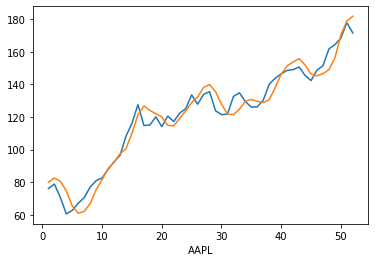

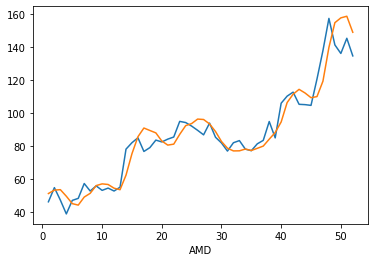

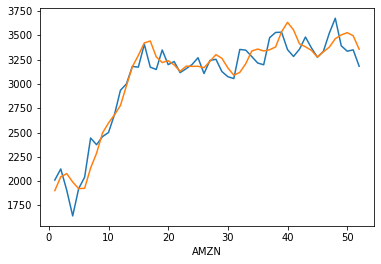

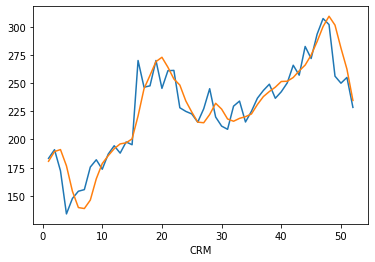

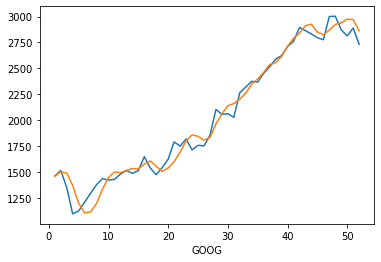

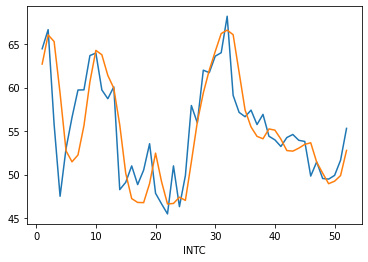

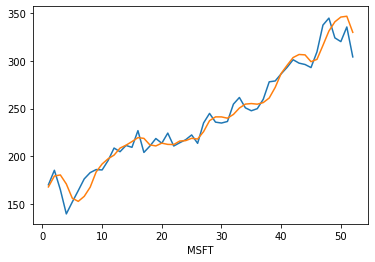

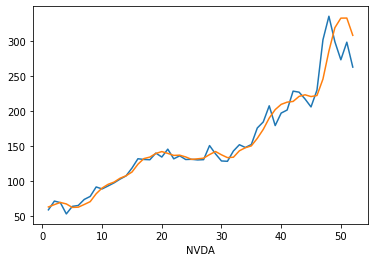

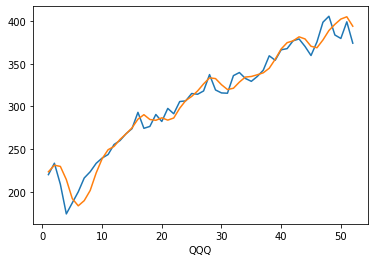

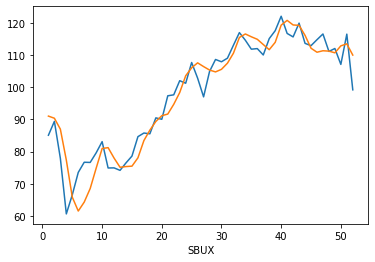

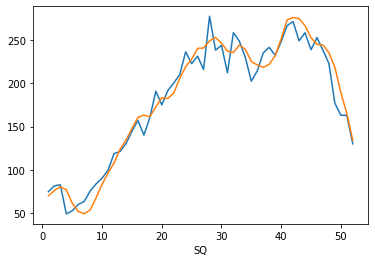

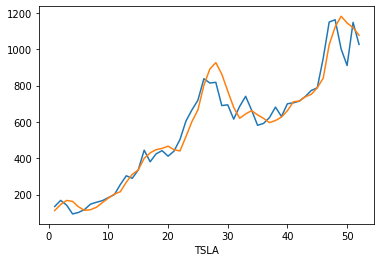

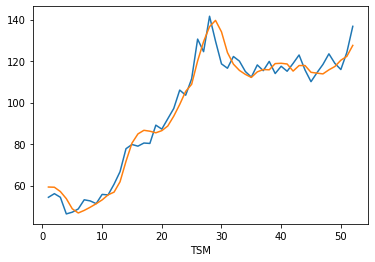

In [485]:
# plot for each stock the open price and the prediction price
# open (blue) below prediction (orange) = stock is underperforming

for i in stock_list:
    x = df['Index']
    y = df[str(i)]
    plt.plot(x, y)

    x = df['Index']
    y = df[str(i) + ' pred']
    plt.plot(x, y)

    plt.xlabel(i)
    plt.show()

#### At this point, the foundation is set and strategies can be created and tested.

In [486]:
# determine the weeks where pred/open is >1 and therefore they are better weeks to buy in
# steady stocks could be at about 50/50 but stocks exponentially rising could have open to 0 pred/open > 1

for j in stock_list:
    nlist = []
    for i in range(len(df)):
        if df[str(j) + ' pred/open'].iloc[i] >= 1:
            nlist.append(1)
        else:
            nlist.append(0)

    df[str(j) + ' >1'] = nlist

df.tail(10)

,Index,AAPL,AAPL pred,AAPL pred/open,AMD,AMD pred,AMD pred/open,AMZN,AMZN pred,AMZN pred/open,...,CRM >1,GOOG >1,INTC >1,MSFT >1,NVDA >1,QQQ >1,SBUX >1,SQ >1,TSLA >1,TSM >1
42,43,150.630005,155.754279,1.034019,105.260002,114.296671,1.085851,3482.800049,3382.528580,0.971210,...,1,1,0,1,0,1,0,1,0,0
43,44,145.470001,151.958433,1.044603,105.070000,112.104923,1.066955,3371.500000,3345.817197,0.992382,...,0,1,0,1,1,1,1,1,0,1
44,45,142.270004,146.271440,1.028126,104.620003,109.263370,1.044383,3275.000000,3277.040389,1.000623,...,1,1,0,1,1,1,0,1,1,1
45,46,148.679993,145.215048,0.976695,120.519997,109.917972,0.912031,3335.000000,3330.998765,0.998800,...,0,1,1,0,0,0,0,0,0,0
46,47,151.410004,146.491413,0.967515,137.699997,119.226363,0.865841,3523.239990,3378.557641,0.958935,...,0,0,0,0,0,0,0,1,0,0
47,48,161.679993,149.001846,0.921585,157.139999,139.607006,0.888424,3676.379883,3465.696705,0.942693,...,1,0,1,0,0,0,1,1,0,0
48,49,164.289993,156.139496,0.950390,141.139999,154.560474,1.095086,3393.000000,3504.558530,1.032879,...,1,1,0,1,1,1,0,1,1,0
49,50,168.279999,170.075329,1.010669,135.970001,157.464880,1.158085,3337.000000,3528.001990,1.057238,...,1,1,0,1,1,1,1,1,1,1
50,51,177.830002,178.840643,1.005683,145.139999,158.445287,1.091672,3351.000000,3496.052665,1.043286,...,1,1,0,1,1,1,0,1,0,0
51,52,171.509995,181.755035,1.059734,134.500000,148.758196,1.106009,3182.100098,3357.437710,1.055101,...,1,1,0,1,1,1,1,1,1,0


In [487]:
# square the pred/open number as a more extreme option for calculations

for j in stock_list:
    df[str(j) +' pred/open2'] = df[str(j) +' pred/open']**2 # make the value differences a little more pronounced

df.tail(10)

,Index,AAPL,AAPL pred,AAPL pred/open,AMD,AMD pred,AMD pred/open,AMZN,AMZN pred,AMZN pred/open,...,CRM pred/open2,GOOG pred/open2,INTC pred/open2,MSFT pred/open2,NVDA pred/open2,QQQ pred/open2,SBUX pred/open2,SQ pred/open2,TSLA pred/open2,TSM pred/open2
42,43,150.630005,155.754279,1.034019,105.260002,114.296671,1.085851,3482.800049,3382.528580,0.971210,...,1.029786,1.033545,0.931159,1.061733,0.947417,1.013091,0.988492,1.216528,0.994630,0.918831
43,44,145.470001,151.958433,1.044603,105.070000,112.104923,1.066955,3371.500000,3345.817197,0.992382,...,0.886711,1.067738,0.966802,1.069065,1.055764,1.048062,1.044260,1.064105,0.946296,1.037664
44,45,142.270004,146.271440,1.028126,104.620003,109.263370,1.044383,3275.000000,3277.040389,1.000623,...,1.022425,1.038843,0.987546,1.042502,1.149160,1.061158,0.986051,1.120384,1.000649,1.083597
45,46,148.679993,145.215048,0.976695,120.519997,109.917972,0.912031,3335.000000,3330.998765,0.998800,...,0.956031,1.035024,1.159494,0.949748,0.934280,0.963816,0.933413,0.939289,0.783494,0.996311
46,47,151.410004,146.491413,0.967515,137.699997,119.226363,0.865841,3523.239990,3378.557641,0.958935,...,0.954310,0.914028,0.998606,0.878241,0.663149,0.898488,0.912588,1.051317,0.795139,0.924350
47,48,161.679993,149.001846,0.921585,157.139999,139.607006,0.888424,3676.379883,3465.696705,0.942693,...,1.049606,0.948226,1.025153,0.923128,0.725306,0.919272,1.001487,1.115155,0.933631,0.878971
48,49,164.289993,156.139496,0.950390,141.139999,154.560474,1.095086,3393.000000,3504.558530,1.032879,...,1.384578,1.047241,0.978769,1.106267,1.138528,1.066088,0.976203,1.522179,1.392040,0.974915
49,50,168.279999,170.075329,1.010669,135.970001,157.464880,1.158085,3337.000000,3528.001990,1.057238,...,1.264668,1.117873,0.973433,1.166770,1.482651,1.123193,1.110467,1.347576,1.579269,1.079015
50,51,177.830002,178.840643,1.005683,145.139999,158.445287,1.091672,3351.000000,3496.052665,1.043286,...,1.058160,1.056845,0.932841,1.067949,1.244258,1.029719,0.948993,1.029177,0.951250,0.970151
51,52,171.509995,181.755035,1.059734,134.500000,148.758196,1.106009,3182.100098,3357.437710,1.055101,...,1.054678,1.097361,0.910573,1.175988,1.375094,1.109024,1.229546,1.063303,1.100640,0.870144


In [488]:
# Create all of the strategies to test 

for j, z in zip(stock_list, contrib_amt):
    
# baseline - buy in $10 bi-weekly no matter what - baseline
    df[str(j) +' baseline'] = 0
    df[str(j) +' baseline_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[str(j) +' baseline'].iloc[i] = z
        df[str(j) +' baseline_stk'].iloc[i] = df[str(j) +' baseline'].iloc[i]/df[str(j)].iloc[i]
        v -= z
        if v < z:
            break

# opt1 - buy in every other week but proportionally to the pred/open
    df[str(j) +' opt1'] = 0
    df[str(j) +' opt1_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[str(j) +' opt1'].iloc[i] = z*df[str(j) +' pred/open'].iloc[i]
        df[str(j) +' opt1_stk'].iloc[i] = df[str(j) +' opt1'].iloc[i]/df[str(j)].iloc[i]
        v -= z*df[str(j) +' pred/open'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < z*df[str(j) +' pred/open'].iloc[t]:
            break

# opt2 - buy in every other week but proportionally to the square of pred/open
    df[str(j) +' opt2'] = 0
    df[str(j) +' opt2_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[str(j) +' opt2'].iloc[i] = z*df[str(j) +' pred/open2'].iloc[i]
        df[str(j) +' opt2_stk'].iloc[i] = df[str(j) +' opt2'].iloc[i]/df[str(j)].iloc[i]
        v -= z*df[str(j) +' pred/open2'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < z*df[str(j) +' pred/open2'].iloc[t]:
            break

# opt3 - buy in every other week. 0 on days <1 and twice the normal bi-weekly contribution on days >= 1
    df[str(j) +' opt3'] = 0
    df[str(j) +' opt3_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[str(j) +' opt3'].iloc[i] = z*2*df[str(j) +' >1'].iloc[i] 
        df[str(j) +' opt3_stk'].iloc[i] = df[str(j) +' opt3'].iloc[i]/df[str(j)].iloc[i]
        v -= z*2*df[str(j) +' >1'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < z*2*df[str(j) +' >1'].iloc[t]:
            break

# opt4 - buy in every other week but proportionally to the inverse of pred/open
# This is more of a validation and will ideally return negative compared to baseline
    df[str(j) +' opt4'] = 0
    df[str(j) +' opt4_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[str(j) +' opt4'].iloc[i] = z/df[str(j) +' pred/open'].iloc[i]
        df[str(j) +' opt4_stk'].iloc[i] = df[str(j) +' opt4'].iloc[i]/df[str(j)].iloc[i]
        v -= z/df[str(j) +' pred/open'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < z/df[str(j) +' pred/open'].iloc[t]:
            break

# opt5
    df[str(j) +' opt5'] = 0
    df[str(j) +' opt5_stk'] = 0
    v = invest
    for i in range(len(df)):
        if df[str(j) +' pred/open2'].iloc[i] < buyvalue:
            df[str(j) +' opt5'].iloc[i] = z
        else:
            df[str(j) +' opt5'].iloc[i] = round(z * df[str(j) +' pred/open2'].iloc[i] * multiplier,0)
                # round because, I really don't want to deal with non-whole dollar amounts in practice
        df[str(j) +' opt5_stk'].iloc[i] = df[str(j) +' opt5'].iloc[i]/df[str(j)].iloc[i]
        v -= z*df[str(j) +' pred/open2'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < z*df[str(j) +' pred/open2'].iloc[t]:
            break

# opt6
    df[str(j) +' opt6'] = 0
    df[str(j) +' opt6_stk'] = 0
    v = invest
    for i in range(len(df)):
        if df[str(j) +' pred/open2'].iloc[i] < buyvalue:
            df[str(j) +' opt6'].iloc[i] = z
        else:
            df[str(j) +' opt6'].iloc[i] = z * multiplier2
        df[str(j) +' opt6_stk'].iloc[i] = df[str(j) +' opt6'].iloc[i]/df[str(j)].iloc[i]
        v -= z*df[str(j) +' pred/open2'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < z*df[str(j) +' pred/open2'].iloc[t]:
            break

df.tail(10)

C:\Users\james\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\james\AppData\Local\Temp/ipykernel_17260/2313187765.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(j) +' opt3'] = 0
C:\Users\james\AppData\Local\Temp/ipykernel_17260/2313187765.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

,Index,AAPL,AAPL pred,AAPL pred/open,AMD,AMD pred,AMD pred/open,AMZN,AMZN pred,AMZN pred/open,...,TSM opt2,TSM opt2_stk,TSM opt3,TSM opt3_stk,TSM opt4,TSM opt4_stk,TSM opt5,TSM opt5_stk,TSM opt6,TSM opt6_stk
42,43,150.630005,155.754279,1.034019,105.260002,114.296671,1.085851,3482.800049,3382.528580,0.971210,...,13.782468,0.112107,0,0.000000,15.648524,0.127286,15,0.122011,15,0.122011
43,44,145.470001,151.958433,1.044603,105.070000,112.104923,1.066955,3371.500000,3345.817197,0.992382,...,15.564958,0.134529,30,0.259291,14.725258,0.127271,15,0.129646,15,0.129646
44,45,142.270004,146.271440,1.028126,104.620003,109.263370,1.044383,3275.000000,3277.040389,1.000623,...,16.253959,0.147656,30,0.272529,14.409779,0.130903,15,0.136265,15,0.136265
45,46,148.679993,145.215048,0.976695,120.519997,109.917972,0.912031,3335.000000,3330.998765,0.998800,...,14.944669,0.130635,0,0.000000,15.027742,0.131361,15,0.131119,15,0.131119
46,47,151.410004,146.491413,0.967515,137.699997,119.226363,0.865841,3523.239990,3378.557641,0.958935,...,13.865255,0.117115,0,0.000000,15.601737,0.131783,15,0.126700,15,0.126700
47,48,161.679993,149.001846,0.921585,157.139999,139.607006,0.888424,3676.379883,3465.696705,0.942693,...,13.184567,0.106758,0,0.000000,15.999409,0.129550,15,0.121457,15,0.121457
48,49,164.289993,156.139496,0.950390,141.139999,154.560474,1.095086,3393.000000,3504.558530,1.032879,...,14.623719,0.123002,0,0.000000,15.191756,0.127780,15,0.126167,15,0.126167
49,50,168.279999,170.075329,1.010669,135.970001,157.464880,1.158085,3337.000000,3528.001990,1.057238,...,16.185231,0.139624,30,0.258799,14.440341,0.124572,15,0.129400,15,0.129400
50,51,177.830002,178.840643,1.005683,145.139999,158.445287,1.091672,3351.000000,3496.052665,1.043286,...,14.552268,0.117234,0,0.000000,15.229005,0.122686,15,0.120841,15,0.120841
51,52,171.509995,181.755035,1.059734,134.500000,148.758196,1.106009,3182.100098,3357.437710,1.055101,...,13.052157,0.095445,0,0.000000,16.080359,0.117589,15,0.109689,15,0.109689


In [489]:
#df
#df.to_csv(f'/Volumes/Google Drive/My Drive/Python/other_projects/data_export.csv', index = False)

In [490]:
print('baseline - contribute consistently every other week')
print('opt1 - buy in every other week proportional to the pred/open variable')
print('opt2 - buy in every other week proportional to the square of pred/open variable')
print('opt3 - contribute twice the normal bi-weekly contrib only on the weeks where pred/open is >=1')
print('opt4 - buy in every other week inversely proportional to the pred/open variable')
print('opt5 - normal buy in, boosted at high pred/open')
print('opt6 - normal buy in, boosted at high pred/open, more consistently')

df_bought_in = pd.DataFrame()
df_profit = pd.DataFrame()
df_diff = pd.DataFrame()

for j in stock_list:
    d = {'name': [str(j) +' baseline', str(j) +' opt1', str(j) +' opt2', str(j) +' opt3', str(j) +' opt4', str(j) +' opt5', str(j) +' opt6']
         ,'bought_in': [
             round(sum(df[str(j) +' baseline']),2),
             round(sum(df[str(j) +' opt1']),2), 
             round(sum(df[str(j) +' opt2']),2), 
             round(sum(df[str(j) +' opt3']),2),
             round(sum(df[str(j) +' opt4']),2),
             round(sum(df[str(j) +' opt5']),2),
             round(sum(df[str(j) +' opt6']),2)]
         ,'stocks_held': [
             round(sum(df[str(j) +' baseline_stk']),4), 
             round(sum(df[str(j) +' opt1_stk']),4), 
             round(sum(df[str(j) +' opt2_stk']),4), 
             round(sum(df[str(j) +' opt3_stk']),4), 
             round(sum(df[str(j) +' opt4_stk']),4), 
             round(sum(df[str(j) +' opt5_stk']),4),
             round(sum(df[str(j) +' opt6_stk']),4)]
#          ,'cost_per_stock': [
#              sum(df[str(j) +' baseline'])/sum(df[str(j) +' baseline_stk']), 
#              sum(df[str(j) +' opt1'])/sum(df[str(j) +' opt1_stk']), 
#              sum(df[str(j) +' opt2'])/sum(df[str(j) +' opt2_stk']), 
#              sum(df[str(j) +' opt3'])/sum(df[str(j) +' opt3_stk']), 
#             sum(df[str(j) +' opt4'])/sum(df[str(j) +' opt4_stk'])]
         ,'profit': [
             round((sum(df[str(j) +' baseline_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' baseline']),2),
             round((sum(df[str(j) +' opt1_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' opt1']),2), 
             round((sum(df[str(j) +' opt2_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' opt2']),2), 
             round((sum(df[str(j) +' opt3_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' opt3']),2), 
             round((sum(df[str(j) +' opt4_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' opt4']),2), 
             round((sum(df[str(j) +' opt5_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' opt5']),2),
             round((sum(df[str(j) +' opt6_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' opt6']),2)]
        }

    df2 = pd.DataFrame(data=d)

    df2['diff'] = 0
    df2['diff'].iloc[1] = round(df2['profit'].iloc[1]-df2['profit'].iloc[0],2)
    df2['diff'].iloc[2] = round(df2['profit'].iloc[2]-df2['profit'].iloc[0],2)
    df2['diff'].iloc[3] = round(df2['profit'].iloc[3]-df2['profit'].iloc[0],2)
    df2['diff'].iloc[4] = round(df2['profit'].iloc[4]-df2['profit'].iloc[0],2)
    df2['diff'].iloc[5] = round(df2['profit'].iloc[5]-df2['profit'].iloc[0],2)
    df2['diff'].iloc[6] = round(df2['profit'].iloc[6]-df2['profit'].iloc[0],2)

    df2['%_diff'] = round((df2['diff']/df2['profit'])*100,2)

    print('')
    print(df2)
    
    df_bought_in[str(j) + ' bought_in'] = df2['bought_in']
    df_profit[str(j) + ' profit'] = df2['profit']
    df_diff[str(j) + ' diff'] = df2['diff']

baseline - contribute consistently every other week
opt1 - buy in every other week proportional to the pred/open variable
opt2 - buy in every other week proportional to the square of pred/open variable
opt3 - contribute twice the normal bi-weekly contrib only on the weeks where pred/open is >=1
opt4 - buy in every other week inversely proportional to the pred/open variable
opt5 - normal buy in, boosted at high pred/open
opt6 - normal buy in, boosted at high pred/open, more consistently

            name  bought_in  stocks_held  profit    diff  %_diff
0  AAPL baseline    1040.00       9.2736  550.51    0.00    0.00
1      AAPL opt1    1042.44       9.3234  556.61    6.10    1.10
2      AAPL opt2    1049.21       9.4250  567.27   16.76    2.95
3      AAPL opt3    1120.00      10.0378  601.58   51.07    8.49
4      AAPL opt4    1041.75       9.2730  548.67   -1.84   -0.34
5      AAPL opt5    1222.00      11.7312  790.03  239.52   30.32
6      AAPL opt6    1160.00      10.8504  700.95  150

C:\Users\james\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\james\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\james\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

In [491]:
# how much was ivested
# no amount should be above the previously set 'invest' amount
# row 0 = baselines. Rows 1-4 = options 1-4
df_bought_in

,AAPL bought_in,AMD bought_in,AMZN bought_in,CRM bought_in,GOOG bought_in,INTC bought_in,MSFT bought_in,NVDA bought_in,QQQ bought_in,SBUX bought_in,SQ bought_in,TSLA bought_in,TSM bought_in
0,1040.00,780.00,520.00,260.00,520.00,780.00,520.00,780.00,520.00,520.00,520.00,1040.00,780.00
1,1042.44,785.51,523.64,261.63,522.35,780.73,521.62,782.51,521.33,520.08,524.82,1051.92,779.08
2,1049.21,797.32,528.70,264.87,526.58,785.23,524.61,790.34,523.96,522.44,537.53,1088.35,780.54
3,1120.00,840.00,560.00,270.00,600.00,690.00,600.00,840.00,580.00,460.00,600.00,960.00,660.00
4,1041.75,780.62,517.72,259.91,519.47,782.80,519.67,782.60,519.91,522.12,522.30,1047.65,783.25
5,1222.00,1137.00,554.00,338.00,583.00,1007.00,555.00,1019.00,581.00,639.00,817.00,1888.00,867.00
6,1160.00,1020.00,540.00,310.00,560.00,930.00,540.00,930.00,560.00,600.00,700.00,1520.00,840.00


In [492]:
# profits made above/below the investment
# row 0 = baselines. Rows 1-4 = options 1-4
df_profit

,AAPL profit,AMD profit,AMZN profit,CRM profit,GOOG profit,INTC profit,MSFT profit,NVDA profit,QQQ profit,SBUX profit,SQ profit,TSLA profit,TSM profit
0,550.51,575.47,42.26,11.63,242.91,9.71,173.18,847.76,142.71,22.02,-47.82,2011.80,455.81
1,556.61,587.32,43.80,12.41,245.20,11.04,174.85,854.14,144.18,22.90,-46.79,2138.62,458.53
2,567.27,605.19,45.90,13.61,249.39,12.59,177.45,866.94,146.64,24.54,-39.27,2413.82,463.28
3,601.58,648.13,35.56,13.93,270.06,21.51,194.31,927.20,151.01,25.62,-116.73,1848.35,443.05
4,548.67,569.10,41.20,11.20,242.39,8.54,172.32,846.99,142.13,21.83,-43.79,1986.94,455.05
5,790.03,959.63,74.17,26.79,324.69,28.35,214.19,1085.32,203.44,54.76,38.21,5084.73,550.02
6,700.95,820.46,61.03,19.32,293.19,21.50,196.61,975.36,181.48,40.64,-29.00,3260.01,518.92


In [493]:
# profits made above/below the baseline profits
# row 0 = baselines. Rows 1-4 = options 1-4
df_diff[1:]

,AAPL diff,AMD diff,AMZN diff,CRM diff,GOOG diff,INTC diff,MSFT diff,NVDA diff,QQQ diff,SBUX diff,SQ diff,TSLA diff,TSM diff
1,6.10,11.85,1.54,0.78,2.29,1.33,1.67,6.38,1.47,0.88,1.03,126.82,2.72
2,16.76,29.72,3.64,1.98,6.48,2.88,4.27,19.18,3.93,2.52,8.55,402.02,7.47
3,51.07,72.66,-6.70,2.30,27.15,11.80,21.13,79.44,8.30,3.60,-68.91,-163.45,-12.76
4,-1.84,-6.37,-1.06,-0.43,-0.52,-1.17,-0.86,-0.77,-0.58,-0.19,4.03,-24.86,-0.76
5,239.52,384.16,31.91,15.16,81.78,18.64,41.01,237.56,60.73,32.74,86.03,3072.93,94.21
6,150.44,244.99,18.77,7.69,50.28,11.79,23.43,127.60,38.77,18.62,18.82,1248.21,63.11


In [494]:
# Final summary calculations
# if you take chosen stocks and apply chosen investment strategies over the course of 2 years, 
# investing bi-weekly, you get these results:

print('Current date/time: ', datetime.datetime.now().strftime("%B %d, %Y %H:%M:%S"))
print('')

print('baseline - contribute consistently every other week')
print('opt1 - buy in every other week proportional to the pred/open variable')
print('opt2 - buy in every other week proportional to the square of pred/open variable')
print('opt3 - contribute twice the normal bi-weekly contrib only on the weeks where pred/open is >=1')
print('opt4 - buy in every other week inversely proportional to the pred/open variable')
print('opt5 - normal buy in, boosted at high pred/open, proportional to the pred/open')
print('opt6 - normal buy in, boosted at high pred/open, more consistently')

print('')

# needed for when baseline total profit is negative
if sum(df_profit.iloc[0]) >= 0:
      x = 1
else:
      x = -1

if sum(df_diff.iloc[1]) >= 0:
      print(round(sum(df_diff.iloc[1]),2), 'opt1 profit over baseline.', 
            round(sum(df_profit.iloc[1]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[1]),2), 'investment.',
            round((sum(df_diff.iloc[1])/sum(df_profit.iloc[0]))*100,2)*x, 'percent above baseline profit.')
else:
      print(round(sum(df_diff.iloc[1]),2), 'opt2 loss compared to baseline.', 
            round(sum(df_profit.iloc[1]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[1]),2), 'investment.',
            round((sum(df_diff.iloc[1])/sum(df_profit.iloc[0]))*100,2)*x, 'percent below baseline profit.')

if sum(df_diff.iloc[2]) >= 0:
      print(round(sum(df_diff.iloc[2]),2), 'opt2 profit over baseline.', 
            round(sum(df_profit.iloc[2]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[2]),2), 'investment.',
            round((sum(df_diff.iloc[2])/sum(df_profit.iloc[0]))*100,2)*x, 'percent above baseline profit.')
else:
      print(round(sum(df_diff.iloc[2]),2), 'opt2 loss compared to baseline.', 
            round(sum(df_profit.iloc[2]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[2]),2), 'investment.',
            round((sum(df_diff.iloc[2])/sum(df_profit.iloc[0]))*100,2)*x, 'percent below baseline profit.')

if sum(df_diff.iloc[3]) >= 0:
      print(round(sum(df_diff.iloc[3]),2), 'opt3 profit over baseline.', 
            round(sum(df_profit.iloc[3]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[3]),2), 'investment.',
            round((sum(df_diff.iloc[3])/sum(df_profit.iloc[0]))*100,2)*x, 'percent above baseline profit.')
else:
      print(round(sum(df_diff.iloc[3]),2), 'opt3 loss compared to baseline.', 
            round(sum(df_profit.iloc[3]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[3]),2), 'investment.',
            round((sum(df_diff.iloc[3])/sum(df_profit.iloc[0]))*100,2)*x, 'percent below baseline profit.')

if sum(df_diff.iloc[4]) >= 0:
      print(round(sum(df_diff.iloc[4]),2), 'opt4 profit over baseline.', 
            round(sum(df_profit.iloc[4]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[4]),2), 'investment.',
            round((sum(df_diff.iloc[4])/sum(df_profit.iloc[0]))*100,2)*x, 'percent above baseline profit.')
else:
      print(round(sum(df_diff.iloc[4]),2), 'opt4 loss compared to baseline.', 
            round(sum(df_profit.iloc[4]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[4]),2), 'investment.',
            round((sum(df_diff.iloc[4])/sum(df_profit.iloc[0]))*100,2)*x, 'percent below baseline profit.')

if sum(df_diff.iloc[5]) >= 0:
      print(round(sum(df_diff.iloc[5]),2), 'opt5 profit over baseline.', 
            round(sum(df_profit.iloc[5]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[5]),2), 'investment.',
            round((sum(df_diff.iloc[5])/sum(df_profit.iloc[0]))*100,2)*x, 'percent above baseline profit.')
else:
      print(round(sum(df_diff.iloc[5]),2), 'opt5 loss compared to baseline.', 
            round(sum(df_profit.iloc[5]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[5]),2), 'investment.',
            round((sum(df_diff.iloc[5])/sum(df_profit.iloc[0]))*100,2)*x, 'percent below baseline profit.')

if sum(df_diff.iloc[6]) >= 0:
      print(round(sum(df_diff.iloc[6]),2), 'opt6 profit over baseline.', 
            round(sum(df_profit.iloc[6]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[6]),2), 'investment.',
            round((sum(df_diff.iloc[6])/sum(df_profit.iloc[0]))*100,2)*x, 'percent above baseline profit.')
else:
      print(round(sum(df_diff.iloc[6]),2), 'opt6 loss compared to baseline.', 
            round(sum(df_profit.iloc[6]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[6]),2), 'investment.',
            round((sum(df_diff.iloc[6])/sum(df_profit.iloc[0]))*100,2)*x, 'percent below baseline profit.')


Current date/time:  January 23, 2022 22:05:03

baseline - contribute consistently every other week
opt1 - buy in every other week proportional to the pred/open variable
opt2 - buy in every other week proportional to the square of pred/open variable
opt3 - contribute twice the normal bi-weekly contrib only on the weeks where pred/open is >=1
opt4 - buy in every other week inversely proportional to the pred/open variable
opt5 - normal buy in, boosted at high pred/open, proportional to the pred/open
opt6 - normal buy in, boosted at high pred/open, more consistently

164.86 opt1 profit over baseline. 5202.81 core profit on 8617.66 investment. 3.27 percent above baseline profit.
509.4 opt2 profit over baseline. 5547.35 core profit on 8719.68 investment. 10.11 percent above baseline profit.
25.63 opt3 profit over baseline. 5063.58 core profit on 8780.0 investment. 0.51 percent above baseline profit.
-35.38 opt4 loss compared to baseline. 5002.57 core profit on 8599.77 investment. -0.7 percen

In [495]:
now = pd.DataFrame()
opts = [f'# >= {buyvalue}', f'# < {buyvalue}', 'Total', f'Rate of >= {buyvalue}']
now['Method'] = opts

for j in stock_list:
    nlist = []
    for i in range(len(opts)):
        if i == 0:
            x = 0 
            for k in range(len(df)-1):
                if df[str(j) + ' pred/open2'].iloc[k] >= buyvalue:
                    x += 1
                else:
                    pass
        elif i == 1: 
            x = 0 
            for k in range(len(df)-1):
                if df[str(j) + ' pred/open2'].iloc[k] < buyvalue:
                    x += 1
                else:
                    pass
        elif i == 2:
            x = len(df)   
        elif i == 3:
            y = 0 
            for k in range(len(df)-1):
                if df[str(j) + ' pred/open2'].iloc[k] >= buyvalue:
                    y += 1
                else:
                    pass
            x = round(y/len(df),4)     
        else: -1
        nlist.append(f'{x}')
    now[str(j)] = nlist

now

,Method,AAPL,AMD,AMZN,CRM,GOOG,INTC,MSFT,NVDA,QQQ,SBUX,SQ,TSLA,TSM
0,# >= 1.2,3,7,1,5,2,5,1,4,2,3,9,12,2
1,# < 1.2,48,44,50,46,49,46,50,47,49,48,42,39,49
2,Total,52,52,52,52,52,52,52,52,52,52,52,52,52
3,Rate of >= 1.2,0.0577,0.1346,0.0192,0.0962,0.0385,0.0962,0.0192,0.0769,0.0385,0.0577,0.1731,0.2308,0.0385


In [496]:
print("Using one of the strategies, Most recent monday's buy in values are listed.")

now = pd.DataFrame()
opts = ['baseline', 'opt1', 'opt2', 'opt3', 'opt4', 'opt5', 'opt6']
now['Method'] = opts

for j, z in zip(stock_list, contrib_amt):
    nlist = []
    for i in range(len(opts)):
        if i == 0:
            x = z
        elif i == 1: 
            x = z * df[str(j) + ' pred/open'].iloc[invest_weeks-1]
        elif i == 2:
            x = z * df[str(j) + ' pred/open2'].iloc[invest_weeks-1]
        elif i == 3:
            x = z * 2 * df[str(j) + ' >1'].iloc[invest_weeks-1]
        elif i == 4: 
            x = z / df[str(j) + ' pred/open'].iloc[invest_weeks-1]
        elif i == 5:
            if df[str(j) +' pred/open2'].iloc[invest_weeks-1] < buyvalue:
                x = z
            else:
                x = round(z * df[str(j) +' pred/open2'].iloc[invest_weeks-1] * multiplier,0)
        elif i == 6:
            if df[str(j) +' pred/open2'].iloc[invest_weeks-1] < buyvalue:
                x = z
            else:
                x = z * multiplier2
        else: -1
        nlist.append(round(x,2))
    now[str(j)] = nlist

now


Using one of the strategies, Most recent monday's buy in values are listed.


,Method,AAPL,AMD,AMZN,CRM,GOOG,INTC,MSFT,NVDA,QQQ,SBUX,SQ,TSLA,TSM
0,baseline,20.00,15.00,10.00,5.00,10.00,15.00,10.00,15.00,10.00,10.00,10.00,20.00,15.00
1,opt1,21.19,16.59,10.55,5.13,10.48,14.31,10.84,17.59,10.53,11.09,10.31,20.98,13.99
2,opt2,22.46,18.35,11.13,5.27,10.97,13.66,11.76,20.63,11.09,12.30,10.63,22.01,13.05
3,opt3,40.00,30.00,20.00,10.00,20.00,0.00,20.00,30.00,20.00,20.00,20.00,40.00,0.00
4,opt4,18.87,13.56,9.48,4.87,9.55,15.72,9.22,12.79,9.50,9.02,9.70,19.06,16.08
5,opt5,20.00,55.00,10.00,5.00,10.00,15.00,10.00,62.00,10.00,37.00,10.00,20.00,15.00
6,opt6,20.00,45.00,10.00,5.00,10.00,15.00,10.00,45.00,10.00,30.00,10.00,20.00,15.00


In [497]:
print(f'Current setup for active use - opt5: {roll_days = }, pred/open2, {buyvalue = }, {multiplier = }, {invest = }')

now.iloc[[0,5]]

Current setup for active use - opt5: roll_days = 65, pred/open2, buyvalue = 1.2, multiplier = 3, invest = inf


,Method,AAPL,AMD,AMZN,CRM,GOOG,INTC,MSFT,NVDA,QQQ,SBUX,SQ,TSLA,TSM
0,baseline,20.0,15.0,10.0,5.0,10.0,15.0,10.0,15.0,10.0,10.0,10.0,20.0,15.0
5,opt5,20.0,55.0,10.0,5.0,10.0,15.0,10.0,62.0,10.0,37.0,10.0,20.0,15.0


In [498]:
print('pred/open2 current values')
for j in stock_list:
    if df[str(j) +' pred/open2'].iloc[invest_weeks-1] < buyvalue:
        print(round(df[str(j) +' pred/open2'].iloc[invest_weeks-1],4), j)
    else:
        print(round(df[str(j) +' pred/open2'].iloc[invest_weeks-1],4), j, '>', buyvalue)

pred/open2 current values
1.123 AAPL
1.2233 AMD > 1.2
1.1132 AMZN
1.0547 CRM
1.0974 GOOG
0.9106 INTC
1.176 MSFT
1.3751 NVDA > 1.2
1.109 QQQ
1.2295 SBUX > 1.2
1.0633 SQ
1.1006 TSLA
0.8701 TSM


#### "Final" notes

Stocks going up parabolically will almost never be above 1, so I can't simply not buy in when pred/open is not above 1. GOOG is like this as of 9/3/2021. This kind of stock will also produce worse than baseline profits for opt1 and opt2 because they won't be investing the full 500 over the course of the investment period. Option 3 is not viable.

Stocks in a big S-curve, flat ~ rise ~ flat, will only have a pred/open above 1 on the latter half of the year, so again, I can't contribute nothing. TSM and TSLA are like this as of 9/3/2021. Option 3 is not viable.

Options 1 and 2 seem to do well on stocks with lots of variation but loses on stocks seeing exponential growth. Missing out on a stock growing exponentially will surely wipe out all gains seen elsewhere. There may be some merit to opt4, the inverse method, but the baseline probably remains the best method if a single method is picked, and based only on daily closing values, for across the board investing.

#### Round 2 running notes - 12/15/2021
rolling 1 quarter has already shown to be better than at least 1 year or 1 month<br>
1 quarter instead of my original hypothesis of 1 year seems to be much more promising<br>
opt2 focus<br>
excluded MDB due to shorter stock lifespan<b>

Current run, 3 year period ending 12/15/2021:<br>
Stocks: 'AAPL', 'AMD', 'AMZN', 'CRM', 'GOOG', 'INTC', 'MSFT', 'NVDA', 'QQQ', 'SBUX', 'SQ', 'TSLA', 'TSM'<br>
Dates '2018-12-15' - '2021-12-15'<br>
Rolling: 65 days (~1 quarter)<br>
353.39 opt2 profit over baseline. 4425.11 core profit on 6425.96 investment. 8.68 percent above baseline profit.<br>
TSLA represents most of the gains over baseline, but no individual stock did worse than baseline.<br>

Worst case end run ending on the worst part of the COVID nosedive:<br>
Stocks: 'AAPL', 'AMD', 'AMZN', 'CRM', 'GOOG', 'INTC', 'MSFT', 'NVDA', 'QQQ', 'SBUX', 'SQ', 'TSLA', 'TSM'<br>
Dates '2017-03-20' - '2020-03-20'<br>
Rolling: 65 days (~1 quarter)<br>
19.21 opt2 profit over baseline. 489.81 core profit on 6408.78 investment. 4.08 percent above baseline profit.<br>
GOOG and SBUX were worse than baseline, but not more than $1 different. Good stability<br>

Best case end run ending right before the COVID drop:<br>
Stocks: 'AAPL', 'AMD', 'AMZN', 'CRM', 'GOOG', 'INTC', 'MSFT', 'NVDA', 'QQQ', 'SBUX', 'SQ', 'TSLA', 'TSM'<br>
Dates '2017-02-14' - '2020-02-14'<br>
Rolling: 65 days (~1 quarter)<br>
18.16 opt2 profit over baseline. 3576.39 core profit on 6445.56 investment. 0.51 percent above baseline profit.<br>
TSLA has 18.40 in gains over baseline, the rest were almost a wash<br>
